In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import sys
from pathlib import Path
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import soundfile as sf
ROOT_PATH = Path().resolve().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse

In [3]:
def octave_filter(fc, bw=1, order=6, fs=48000):
    lower = fc / 2**(bw / 2)
    upper = min(fs / 2- 1e-9, fc * 2**(bw / 2))
    wn = np.array([lower, upper])
    sos = signal.butter(N=order, Wn=wn, btype='bandpass', analog=False, output='sos', fs=fs)
    w, h = signal.sosfreqz(sos, worN=fs)
    return w * fs / (2*np.pi), 20 * np.log10(abs(h) + 1e-15), sos

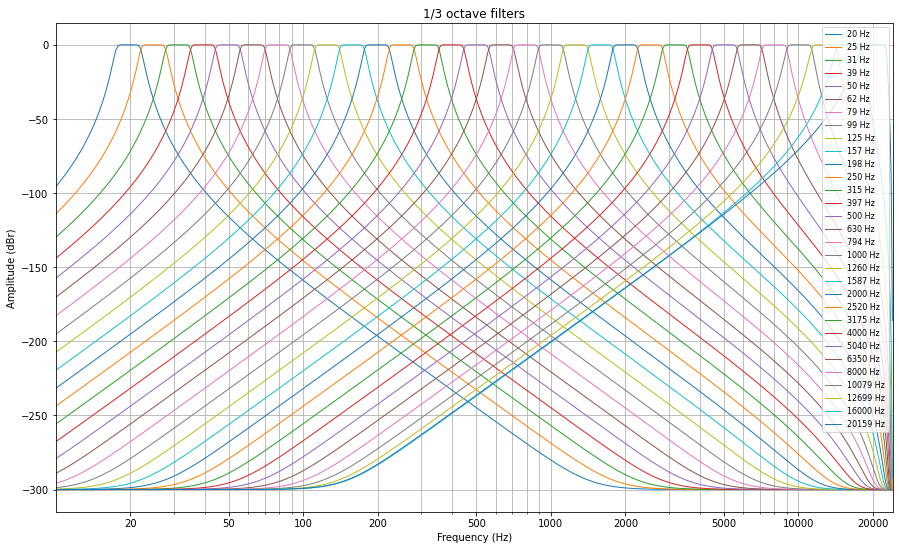

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
fcs = [1000.0 * (2**(1/3))**n for n in range(-17, 14)]
frs = []
soses = []
fs = 48000
for i, fc in enumerate(fcs):
    f, g, sos = octave_filter(fc, bw=1/3, fs=fs)
    fr = FrequencyResponse(name='fc', frequency=f[1:], raw=g[1:])
    fr.interpolate(f_min=10, f_max=fs/2)
    frs.append(fr)
    soses.append(sos)
    fr.plot_graph(fig=fig, ax=ax, show=False, raw_plot_kwargs={'color': f'C{i}', 'label': f'{fc:.0f} Hz'})
ax.set_title('1/3 octave filters')
ax.set_xlim([10, fs/2])
plt.show()

In [51]:
white = np.random.uniform(low=-1.0, high=1.0, size=int(fs * 10))
for fc, sos in zip(fcs, soses):
    filtered = signal.sosfilt(sos, white)
    filtered = filtered / np.max(filtered) * 10**(-3 / 20)  # -3dB
    audio = np.stack([filtered, filtered]).T
    wavfile.write(f'{fc:.0f}Hz.wav', fs, audio)